In [1]:
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from getdist.mcsamples import MCSamples
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [2]:
SAMPLE_DIR = "../output/BOSS_DR12_NGC_z1/samples"

NDDIM = 18
NPARA = 2
NREF = 2048
NSAMP = [NREF, 30, 24]
CASES = [
    ['cov', 'sample', "Sample"],
    ['cov', 'shrinkage_emp', "Covariance shrinkage, target $\mathbf{T}^{(1)}$ (empirical)"],
    ['cov', 'shrinkage_ana', "Covariance shrinkage, target $\mathbf{T}^{(2)}$ (analytical)"],
    ['cov', 'NERCOME', "NERCOME"],
    ['pre', 'shrinkage_emp', "Precision shrinkage, target $\mathbf{\Pi}_0^{(1)}$ (empirical)"],
    ['pre', 'shrinkage_ana', "Precision shrinkage, target $\mathbf{\Pi}_0^{(2)}$ (analytical)"],
]
MARKERS = ['+', 's', 'D', 'x', '1', '2', '3']
MARKERSIZES = [9.5, 7.5, 7.5, 7.5, 10, 10, 10]
SIZES = [8.5, 6, 6, 7.5, 10, 10, 10]
COLORS = ['k', 'r', 'b']

In [3]:
results_file_ref = f"{SAMPLE_DIR}/n2048/cov_sample/cov_sample_2048_results_v1.npy"
results_ref = np.load(results_file_ref, allow_pickle=True)[()]

samples_ref = MCSamples(
    samples=results_ref['samples'], names=['b', 'f']
)

b_ref, f_ref = samples_ref.means
sigma_b_ref, sigma_f_ref = samples_ref.sddev

# marge_stats_ref = samples_ref.getMargeStats()
# uncert_b_ref, uncert_f_ref = [
#     (
#         marge_stats_ref.parWithName('b').limits[0].lower - b_ref,
#         marge_stats_ref.parWithName('b').limits[0].upper - b_ref,
#     ),
#     (
#         marge_stats_ref.parWithName('f').limits[0].lower - f_ref,
#         marge_stats_ref.parWithName('f').limits[0].upper - f_ref,
#     ),
# ]

# print(
#     f"b_ref = {b_ref:.3f} +{uncert_b_ref[1]:.3f} {uncert_b_ref[0]:.3f}",
#     f"| sigma_b_ref = {sigma_b_ref:.3f}"
# )
# print(
#     f"f_ref = {f_ref:.3f} +{uncert_f_ref[1]:.3f} {uncert_f_ref[0]:.3f}",
#     f"| sigma_f_ref = {sigma_f_ref:.3f}"
# )

Removed no burn in


In [4]:
inflation = {}
for idx_nsamp, nsamp in enumerate(NSAMP):
    A_ = 2 / ((nsamp - NDDIM - 1) * (nsamp - NDDIM - 4))
    B_ = (nsamp - NDDIM - 2) / ((nsamp - NDDIM - 1) * (nsamp - NDDIM - 4))
    m_ = (1 + B_ * (NDDIM - NPARA)) / (1 + A_ + B_ * (NPARA + 1))
    inflation[nsamp] = np.sqrt(m_)

In [5]:
pars_means_alt = {}
pars_stds_alt = {}
for idx_nsamp, nsamp in enumerate(NSAMP):
    for idx_case, case in enumerate(CASES):
        mat_type = case[0]
        est_type = case[1]

        if nsamp == NREF:
            results_file = f"{SAMPLE_DIR}/n{nsamp}/{mat_type}_{est_type}/{mat_type}_{est_type}_{nsamp}_results_v1.npy"
            results = np.load(results_file, allow_pickle=True)[()]

            b_mean, f_mean = np.mean(results['samples'], axis=0)
            b_std, f_std = np.std(results['samples'], ddof=1, axis=0)
        else:
            result_files = [
                fn for fn in os.listdir(f"{SAMPLE_DIR}/n{nsamp}/{mat_type}_{est_type}")
                if not fn.startswith('.')
            ]

            b_mean, b_std = [], []
            f_mean, f_std = [], []
            for fn in result_files:
                results = np.load(
                    f"{SAMPLE_DIR}/n{nsamp}/{mat_type}_{est_type}/{fn}",
                    allow_pickle=True
                )[()]
                b_mean_, f_mean_ = np.mean(results['samples'], axis=0)
                b_std_, f_std_ = np.std(results['samples'], ddof=1, axis=0)
                b_mean.append(b_mean_)
                b_std.append(b_std_)
                f_mean.append(f_mean_)
                f_std.append(f_std_)

            b_mean = np.mean(b_mean)
            b_std = np.mean(b_std)
            f_mean = np.mean(f_mean)
            f_std = np.mean(f_std)

        pars_means_alt[(idx_nsamp, idx_case)] = (b_mean, f_mean)
        pars_stds_alt[(idx_nsamp, idx_case)] = (b_std, f_std)

In [6]:
pars_means = {}
pars_stds = {}
for idx_nsamp, nsamp in enumerate(NSAMP):
    for idx_case, case in enumerate(CASES):
        mat_type = case[0]
        est_type = case[1]
        if nsamp == NREF:
            results_file = f"{SAMPLE_DIR}/n{nsamp}/{mat_type}_{est_type}/{mat_type}_{est_type}_{nsamp}_results_v1.npy"
            results = np.load(results_file, allow_pickle=True)[()]

            b_mean, f_mean = np.mean(results['samples'], axis=0)
            b_std, f_std = np.std(results['samples'], ddof=1, axis=0)
        else:
            sample_file = f"{SAMPLE_DIR}/n{nsamp}/{mat_type}_{est_type}_{nsamp}.npy"
            samples = np.load(sample_file, allow_pickle=True)[()]
            
            b_mean, f_mean = samples.means
            b_std, f_std = samples.sddev

        pars_means[(idx_nsamp, idx_case)] = (b_mean, f_mean)
        pars_stds[(idx_nsamp, idx_case)] = (b_std, f_std)

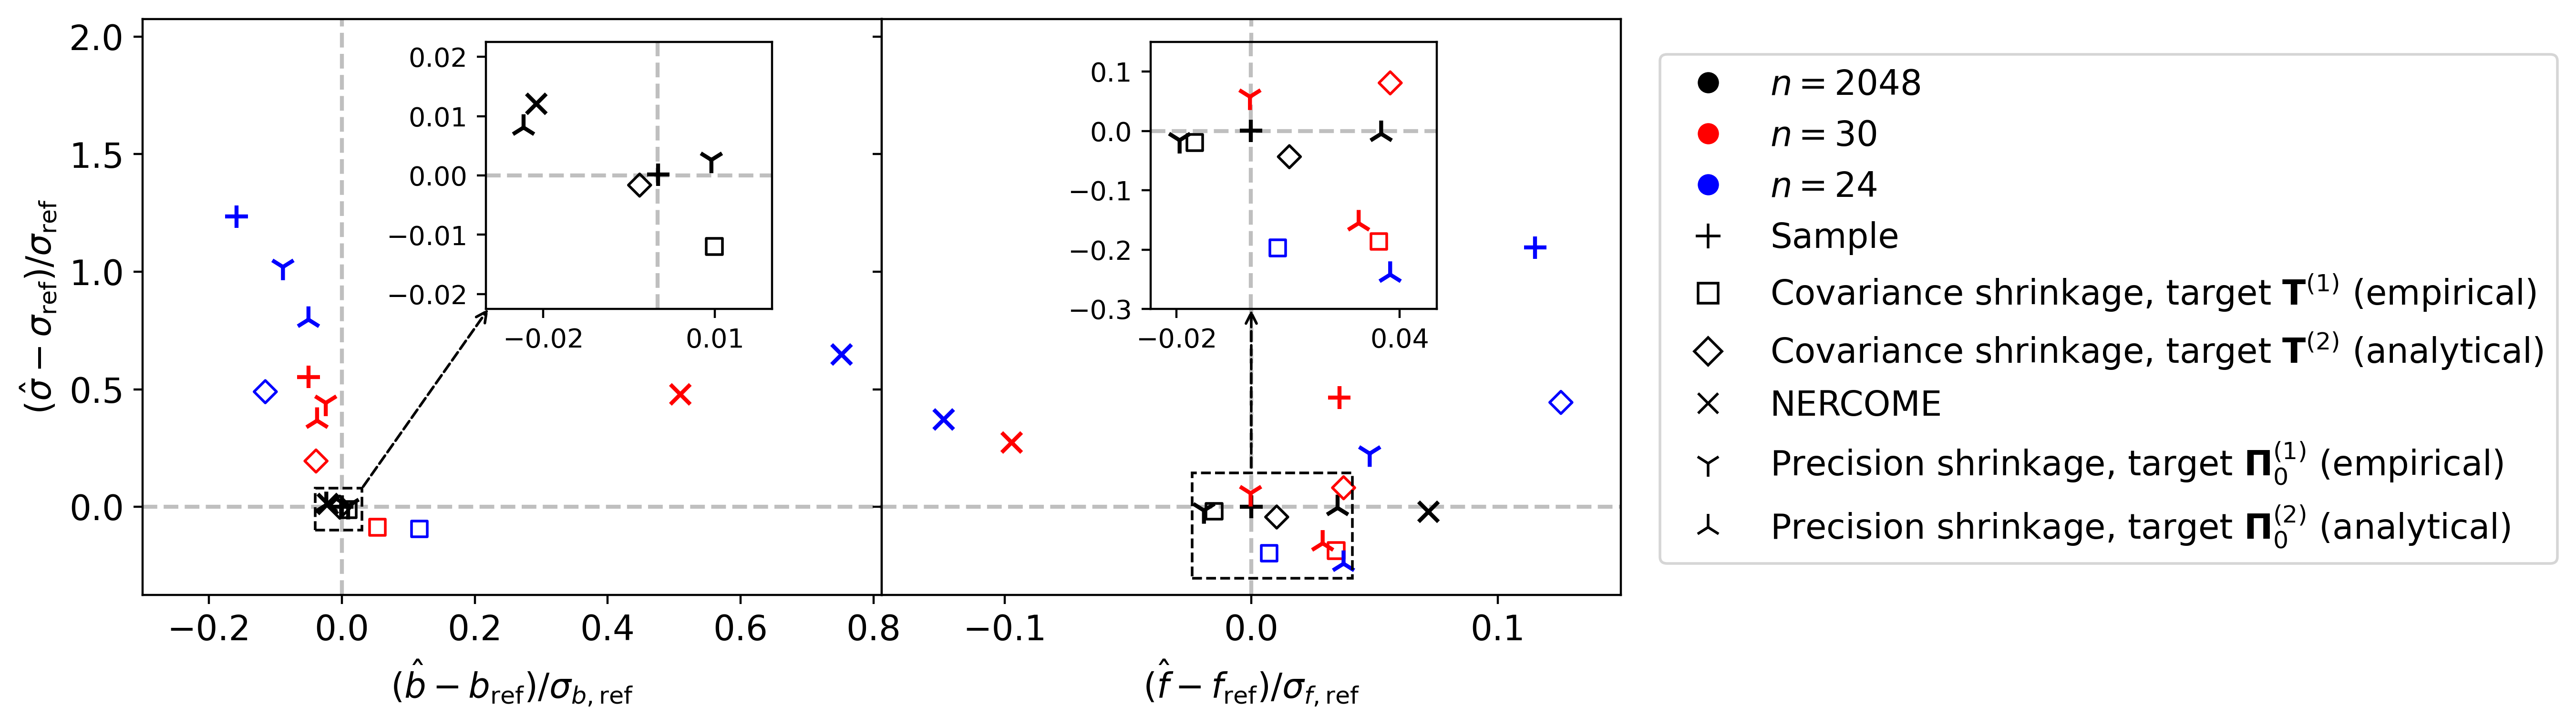

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4), dpi=400)

ax_in_b = fig.add_axes([0.305, 0.5, 0.15, 0.35])
ax_in_f = fig.add_axes([0.6535, 0.5, 0.15, 0.35])

for idx_nsamp, nsamp in enumerate(NSAMP):
    for idx_case, case in enumerate(CASES):
        x_b = (pars_means[(idx_nsamp, idx_case)][0] - b_ref) / sigma_b_ref
        y_b = pars_stds[(idx_nsamp, idx_case)][0] / sigma_b_ref - 1
        x_f = (pars_means[(idx_nsamp, idx_case)][1] - f_ref) / sigma_f_ref
        y_f = pars_stds[(idx_nsamp, idx_case)][1] / sigma_f_ref - 1
        if idx_case == 0:
            msqrt = 1. # inflation[nsamp] / inflation[NREF]
        else:
            msqrt = 1.

        axs[0].scatter(
            x_b, msqrt * y_b,
            marker=MARKERS[idx_case], s=SIZES[idx_case]**2,
            ec=COLORS[idx_nsamp], fc='none'
        )
        axs[1].scatter(
            x_f, msqrt * y_f,
            marker=MARKERS[idx_case], s=SIZES[idx_case]**2,
            ec=COLORS[idx_nsamp], fc='none'
        )

        ax_in_b.scatter(
            x_b, msqrt * y_b,
            marker=MARKERS[idx_case], s=SIZES[idx_case]**2,
            ec=COLORS[idx_nsamp], fc='none'
        )
        ax_in_f.scatter(
            x_f, msqrt * y_f,
            marker=MARKERS[idx_case], s=SIZES[idx_case]**2,
            ec=COLORS[idx_nsamp], fc='none'
        )

axs[0].axvline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)
axs[0].axhline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)

axs[1].axvline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)
axs[1].axhline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)

ax_in_b.axvline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)
ax_in_b.axhline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)

ax_in_f.axvline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)
ax_in_f.axhline(0, ls="dashed", c="k", alpha=0.25, zorder=-1)

axs[0].add_patch(
    Rectangle(
        (-0.04, -0.1), 0.07, 0.18,
        fill=False,
        ls='--',
        edgecolor='k',
        facecolor='none',
    )
)
axs[0].annotate(
    '',
    xy=(0.225, 0.86),
    xycoords='data',
    xytext=(0.0275, 0.0675),
    textcoords='data',
    arrowprops=dict(arrowstyle='->', ls='--', lw=1, color='k')
)

axs[1].add_patch(
    Rectangle(
        (-0.024, -0.305), 0.065, 0.45,
        fill=False,
        ls='--',
        edgecolor='k',
        facecolor='none',
    )
)
axs[1].annotate(
    '',
    xy=(0., 0.86),
    xycoords='data',
    xytext=(0., 0.145),
    textcoords='data',
    arrowprops=dict(arrowstyle='->', ls='--', lw=1, color='k')
)

axs[0].set_xlim(-0.3, 0.8125)
axs[0].set_ylim(-0.375, 2.075)
axs[0].set_xticks([-0.2, 0., 0.2, 0.4, 0.6, 0.8])
axs[0].set_xlabel(r"$(\hat{b} - b_\mathrm{ref}) / \sigma_{b,\mathrm{ref}}$", fontsize=13)
axs[0].set_ylabel(r"$(\hat{\sigma} - \sigma_\mathrm{ref}) / \sigma_\mathrm{ref}$", fontsize=13)
axs[0].tick_params(axis='both', which='major', labelsize=13)

axs[1].set_xlim(-0.15, 0.15)
axs[1].set_xticks([-0.10, 0., 0.1])
axs[1].set_xlabel(r"$(\hat{f} - f_\mathrm{ref}) / \sigma_{f,\mathrm{ref}}$", fontsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)

ax_in_b.set_xticks([-0.02, 0.01])
ax_in_b.set_xlim(-0.03, 0.02)
ax_in_b.set_ylim(-0.0225, 0.0225)

ax_in_f.set_xticks([-0.02, 0.04])
ax_in_f.set_xlim(-0.027, 0.05)
ax_in_f.set_ylim(-0.3, 0.15)

lgd_items = [
    Line2D(
        [0], [0], marker='o', color='w',
        markersize=9,
        markerfacecolor=color,
        label=fr'$n={nsamp}$'
    )
    for nsamp, color in zip(NSAMP, COLORS)
]
for idx_case, case in enumerate(CASES):
    lgd_items.append(
        Line2D(
            [0], [0],
            marker=MARKERS[idx_case],
            color='w',
            label=case[2],
            markerfacecolor='none', markeredgecolor='k',
            markersize=MARKERSIZES[idx_case]
        )
    )

fig.legend(
    handles=lgd_items,
    loc="center right", bbox_to_anchor=(1.4, 0.5),
    ncol=1, fontsize=13
)

fig.subplots_adjust(wspace=0)

fig.savefig("../output/BOSS_DR12_NGC_z1/plots/inferred_params.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

In [8]:
print(inflation)

{2048: 1.0031966183541465, 30: 1.4375905768565218, 24: 1.755942292142123}
